In [1]:
using Revise
using Plots
using nnsim

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling nnsim [2a7ddd44-2043-11ea-1b23-d1c817c05b75]
└ @ Base loading.jl:1260


In [2]:
struct LIF{T<:Number,A<:AbstractArray{T, 1}}<:AbstractNeuron 
    τ::T
    R::T
    θ::T
    I::T

    v0::T
    state::A
    output::A
end

In [3]:
function nnsim.update!(neuron::LIF, input_update, dt, t) 
    neuron.output[1] = 0 # Reset spikesa
    neuron.state[1] += input_update # If an impulse came in, add it

    # Euler method update
    neuron.state[1] += (dt/neuron.τ) * (-neuron.state[1] + neuron.R*neuron.I)

    # Check for spiking
    if neuron.state[1] >= neuron.θ
        neuron.state[1] = neuron.v0
        neuron.output[1] = 1 # Binary output
    end

    return neuron.output[1] 
end

function nnsim.reset!(neuron::LIF)
   neuron.state[1] = neuron.v0 
end

In [4]:
neuronLIF = LIF(8., 10.E2, 30., 40., -55., [-55.], [0.])

LIF{Float64,Array{Float64,1}}(8.0, 1000.0, 30.0, 40.0, -55.0, [-55.0], [0.0])

In [5]:
println(neuronLIF.state)
update!(neuronLIF, 0., 0.001, 0)
println(neuronLIF.state)

[-55.0]
[-49.993125]


In [5]:
LIFsim = simulate!(neuronLIF, (t)->0.4*exp(-4t), 0.0001, 0.250, track_state=true);

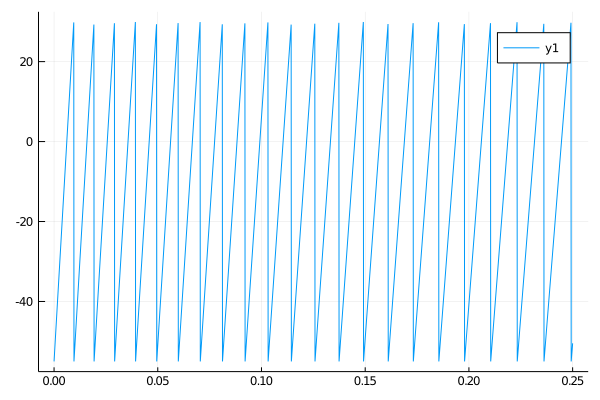

In [6]:
plot(LIFsim.times, reshape(LIFsim.states, :))

Layers

In [7]:
using Random

In [13]:
N = 8;
neurons = [LIF(8., 10.E2, 30., 40., -55., [-55.], [0.]) for _ in 1:N];
weights = randn(MersenneTwister(13371485), N,2);
layer = Layer(neurons, weights);

In [14]:
reset!(layer)
update!(layer, [[0.5, 0.8]], 0.001, 0)
println(nnsim.get_neuron_states(layer))

[-49.541978928637135, -49.60578871324857, -50.60465974476108, -51.33312701157462, -49.74745195528637, -51.714553064661985, -49.368426839446435, -50.84036022383181]


In [15]:
layersim = simulate!(layer, (t) -> [randn(2)], 0.001, 0.25, track_state=true);

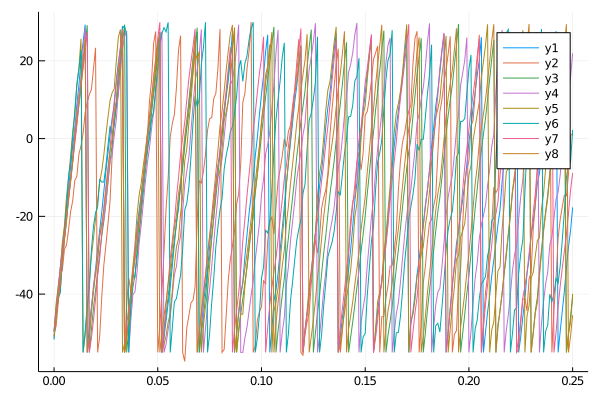

In [12]:
plot(layersim.times, layersim.states')

Network

In [16]:
Nin = 2

2

In [17]:
N1 = 3
neurons1 = [LIF(8., 10.E2, 30., 40., -55., [-55.], [0.]) for _ in 1:N1]
weights1 = randn(MersenneTwister(13371485), N1, Nin)
layer1 = Layer(neurons1, weights1);

In [18]:
using BlockArrays
N2 = 4;
neurons2 = [LIF(8., 10.E2, 30., 40., -55., [-55.], [0.]) for _ in 1:N2]
W21 = randn(N2, N1) # connections from layer 1
W22 = 5*randn(N2, N2) # Recurrent connections
weights2 = BlockArray(zeros(N2, Nin+N1+N2), [N2], [Nin, N1, N2])
weights2[Block(1,2)] .= W21
weights2[Block(1,3)] .= W22

conns = [1, 2]

layer2 = Layer(neurons2, weights2, conns);

In [19]:
mynet = Network([layer1, layer2]);

In [20]:
reset!(mynet)
update!(mynet, 0.4*ones(Nin), 0.001, 0)
println(nnsim.get_neuron_states(mynet))

[-49.61444931320574, -50.42051080817629, -49.602555529612104, -49.993125, -49.993125, -49.993125, -49.993125]


In [28]:
reset!(mynet)
netsim = simulate!(mynet, (t) -> 0.4*ones(Nin), 0.001, 1, track_state=true);

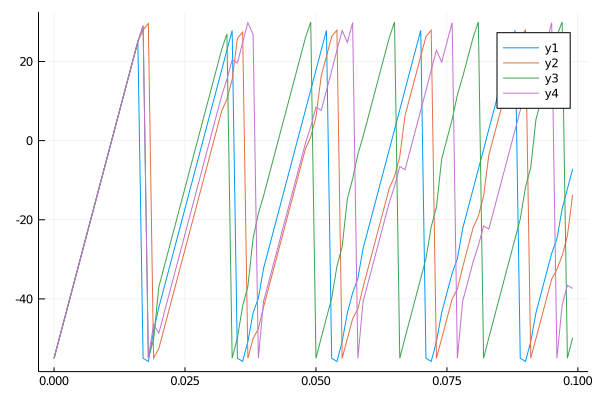

In [30]:
plot(netsim.times[1:100], netsim.states[4:end,1:100]')